<a href="https://colab.research.google.com/github/P55D2K/cca-ml/blob/main/darrel_mnist_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

64400.1015625
64284.96875
64170.0625
64055.38671875
63940.91796875
63826.66796875
63712.6484375
63598.8359375
63485.2421875
63371.86328125
63258.70703125
63145.7578125
63033.01953125
62920.51171875
62808.20703125
62696.11328125
62584.23046875
62472.57421875
62361.1328125
62249.88671875


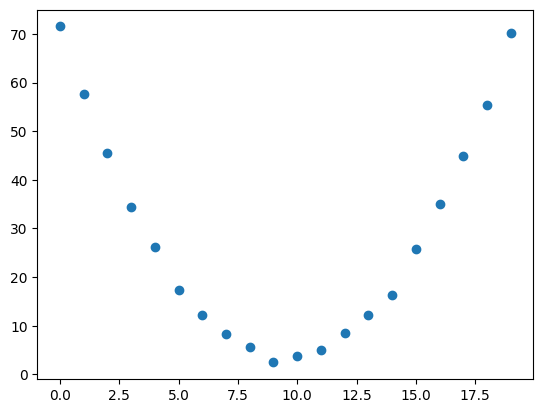

In [1]:
import torch
import matplotlib.pyplot as plt
weight = torch.arange(0,20).float(); weight
x = torch.rand(20)*3 + 0.75*(weight-9.5)**2+1
plt.scatter(weight,x)

params = torch.randn(3).requires_grad_()
orig_params = torch.randn(3).requires_grad_().clone()

# Quadratic function
def f(z, params):
    a,b,c = params
    return a*(z**2)+(b*z)+c

# Calculate loss via MSE
def mse(preds, targets):
    return ((preds-targets)**2).mean.sqrt()

from fastai.vision.all import * # pip install fastai if needed
def show_predicted(preds, ax=None):
    if ax is None: ax=plt.subplots()[1]
    ax.scatter(weight,x)
    ax.scatter(weight, to_np(preds), color='red')
    ax.set_ylim(-200,200)
    show_predicted(preds)
    loss = mse(preds, x)
    loss

    loss.backward()
learn_rate = 1e-3
orig_params.data -= learn_rate* orig_params
orig_params.grad = None
orig_params

def apply_step(orig_params, prn=True):
    preds = f(weight, orig_params)
    loss = mse(preds, x)
    loss.backward()
    orig_params.data -= learn_rate * orig_params
    orig_params.grad = None
    if prn: print(loss.item())
    return preds
for i in range (20):
    apply_step(orig_params)

In [ ]:
# import libraries
import torch
!nvidia-smi
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



device(type='cpu')

In [2]:
#Download MNIST dataset in local system
from torchvision import datasets
from torchvision.transforms import ToTensor
train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

100%|██████████| 9912422/9912422 [00:00<00:00, 11242585.63it/s]


Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw



100%|██████████| 28881/28881 [00:00<00:00, 14465690.69it/s]

Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw



100%|██████████| 1648877/1648877 [00:00<00:00, 10165958.49it/s]


Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw



100%|██████████| 4542/4542 [00:00<00:00, 4521844.00it/s]

Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw



In [3]:
print(train_data)
print(test_data)
print(train_data.data.size())
print(train_data.targets.size())

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()
torch.Size([60000, 28, 28])
torch.Size([60000])


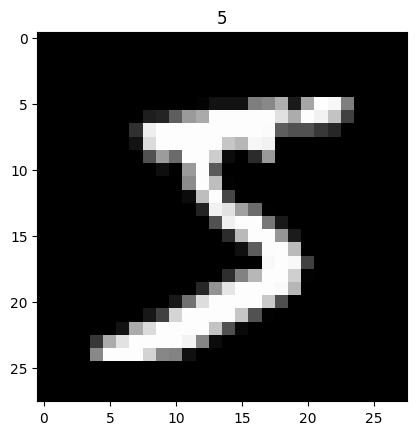

In [4]:
#Visualization of MNIST dataset
#Plot one train_data

import matplotlib.pyplot as plt
plt.imshow(train_data.data[0], cmap='gray')
plt.title('%i' % train_data.targets[0])
plt.show()

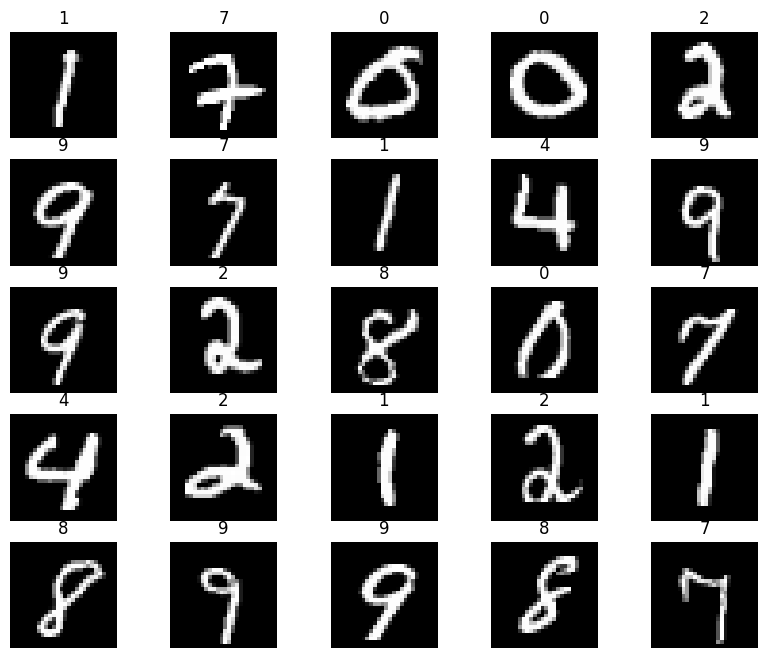

In [5]:
#Plot multiple train_data

figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [6]:
from torch.utils.data import DataLoader
loaders = {
    'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
}
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x25ea21cf390>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x25ea2089250>}

In [7]:
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output, x    # return x for visualization

In [8]:
cnn = CNN()
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


In [9]:
#Loss function

loss_func = nn.CrossEntropyLoss()   
loss_func


CrossEntropyLoss()

lr(Learning Rate): Rate at which our model updates the weights in the cells each time back-propagation is done.

In [10]:
#Optimization Function

from torch import optim
optimizer = optim.Adam(cnn.parameters(), lr = 0.01)   
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)

In [11]:
from torch.autograd import Variable
num_epochs = 10
def train(num_epochs, cnn, loaders):
    
    cnn.train()
        
    # Train the model
    total_step = len(loaders['train'])
        
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):
            
            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images)   # batch x
            b_y = Variable(labels)   # batch y
            output = cnn(b_x)[0]               
            loss = loss_func(output, b_y)
            
            # clear gradients for this training step   
            optimizer.zero_grad()           
            
            # backpropagation, compute gradients 
            loss.backward()    
            # apply gradients             
            optimizer.step()                
            
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
                pass
        pass
    pass
train(num_epochs, cnn, loaders)

Epoch [1/10], Step [100/600], Loss: 0.1265
Epoch [1/10], Step [200/600], Loss: 0.1644
Epoch [1/10], Step [300/600], Loss: 0.0594
Epoch [1/10], Step [400/600], Loss: 0.1616
Epoch [1/10], Step [500/600], Loss: 0.0658
Epoch [1/10], Step [600/600], Loss: 0.1339
Epoch [2/10], Step [100/600], Loss: 0.0291
Epoch [2/10], Step [200/600], Loss: 0.0645
Epoch [2/10], Step [300/600], Loss: 0.0137
Epoch [2/10], Step [400/600], Loss: 0.0226
Epoch [2/10], Step [500/600], Loss: 0.0448
Epoch [2/10], Step [600/600], Loss: 0.0481
Epoch [3/10], Step [100/600], Loss: 0.0008
Epoch [3/10], Step [200/600], Loss: 0.0900
Epoch [3/10], Step [300/600], Loss: 0.0070
Epoch [3/10], Step [400/600], Loss: 0.0197
Epoch [3/10], Step [500/600], Loss: 0.1599
Epoch [3/10], Step [600/600], Loss: 0.0961
Epoch [4/10], Step [100/600], Loss: 0.1151
Epoch [4/10], Step [200/600], Loss: 0.0459
Epoch [4/10], Step [300/600], Loss: 0.0694
Epoch [4/10], Step [400/600], Loss: 0.0076
Epoch [4/10], Step [500/600], Loss: 0.1582
Epoch [4/10

In [12]:
def test():
    # Test the model
    cnn.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loaders['test']:
            test_output, last_layer = cnn(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
            print('Test Accuracy of the model on the 10000 test images: %.2f' % accuracy)
            pass
    pass
test()

Test Accuracy of the model on the 10000 test images: 0.99
Test Accuracy of the model on the 10000 test images: 0.99
Test Accuracy of the model on the 10000 test images: 0.99
Test Accuracy of the model on the 10000 test images: 0.99
Test Accuracy of the model on the 10000 test images: 0.98
Test Accuracy of the model on the 10000 test images: 0.98
Test Accuracy of the model on the 10000 test images: 0.98
Test Accuracy of the model on the 10000 test images: 1.00
Test Accuracy of the model on the 10000 test images: 0.99
Test Accuracy of the model on the 10000 test images: 0.96
Test Accuracy of the model on the 10000 test images: 0.97
Test Accuracy of the model on the 10000 test images: 1.00
Test Accuracy of the model on the 10000 test images: 0.95
Test Accuracy of the model on the 10000 test images: 1.00
Test Accuracy of the model on the 10000 test images: 0.98
Test Accuracy of the model on the 10000 test images: 0.99
Test Accuracy of the model on the 10000 test images: 0.99
Test Accuracy 

In [13]:
sample = next(iter(loaders['test']))
imgs, lbls = sample

actual_number = lbls[:700].numpy()
actual_number

array([5, 2, 0, 4, 8, 7, 3, 3, 9, 7, 4, 5, 3, 4, 9, 6, 7, 2, 9, 1, 1, 3,
       9, 0, 0, 7, 1, 0, 6, 1, 8, 0, 4, 4, 8, 4, 6, 1, 6, 9, 3, 1, 1, 1,
       5, 7, 3, 9, 7, 7, 2, 4, 1, 0, 5, 5, 4, 9, 9, 7, 0, 4, 0, 2, 5, 3,
       5, 0, 4, 6, 9, 9, 1, 7, 8, 2, 2, 3, 0, 1, 2, 9, 1, 9, 2, 2, 1, 4,
       4, 9, 5, 8, 1, 9, 1, 0, 0, 3, 6, 1], dtype=int64)

In [14]:
test_output, last_layer = cnn(imgs[:700])
pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
print(f'Prediction number: {pred_y}')
print(f'Actual number: {actual_number}')

Prediction number: [5 2 0 4 8 7 3 3 9 7 4 5 3 4 9 6 7 2 9 1 1 3 9 0 0 7 1 0 6 1 8 0 4 4 8 9 6
 1 6 9 3 1 1 1 5 7 3 9 7 7 2 4 1 0 5 5 4 9 9 7 0 4 0 2 5 3 5 0 4 6 9 9 1 9
 8 2 2 3 0 1 2 9 1 9 2 2 1 9 4 9 5 8 1 9 1 0 0 3 6 1]
Actual number: [5 2 0 4 8 7 3 3 9 7 4 5 3 4 9 6 7 2 9 1 1 3 9 0 0 7 1 0 6 1 8 0 4 4 8 4 6
 1 6 9 3 1 1 1 5 7 3 9 7 7 2 4 1 0 5 5 4 9 9 7 0 4 0 2 5 3 5 0 4 6 9 9 1 7
 8 2 2 3 0 1 2 9 1 9 2 2 1 4 4 9 5 8 1 9 1 0 0 3 6 1]
